<ul><li>American Gut Project
</li><li>License: BSD
</li><li>Last Update: April 2014
</li></ul>

The following libraries will need to be installed
</li><li><a href="https://www.python.org/download/releases/2.7/">Python 2.7</a>
</li><li><a href="http://pycogent.org/">Pycogent 1.5.3</a>
</li><li><a href="http://picrust.github.io/picrust/install.html#install">PiCRUST</a>
</li><li><a href="http://biom-format.org/index.html">BIOM 1.3.1</a>
</li><li><a href="http://www.numpy.org/">Numpy 1.5.1</a>
</li><li><a href="http://www.scipy.org">SciPy</a>
</li><li><a href="http://pandas.pydata.org">pandas</a>
</li><li><a href="http://statsmodels.sourceforge.net/">statsmodels</a>
</li><li><a href="https://www.gnu.org/software/tar/">The tar utility</a>
</li></ul>

It is suggested to install these packages via pip and virtualenv (with the exception of python and picrust)

[Picrust](http://www.nature.com/nbt/journal/v31/n9/full/nbt.2676.html) [1]
is a tool that estimates metagenome gene abundances just given 16S sequencing data.

This is done using phylogenetic infererence. Many of the bacteria mapped in the Greengenes database have full metagenomic profiles.  These metagenomic profiles are typically made up of gene annotations, annotated by [KEGG](http://www.oxfordjournals.org/our_journals/nar/database/summary/112), [COG](http://www.ncbi.nlm.nih.gov/COG/) or [RFAM](http://www.ncbi.nlm.nih.gov/pubmed/12520045). If a bacteria's 16S gene maps to one of the 16S genes in the Greengenes database, it has been shown that that bacteria will have also have a very similar metagenomic profile to the bacteria mapped in the Greengenes database.

In this tutorial, we using 16S genes to predict the KEGG proportions in the samples.

Note that this methodology is highly reliant on the integrity of the reference phylogenetic tree. Environments with poor bacterial reference genomes such as soil, will not yield meaningful predictions.

In this tutorial, we will be applying Picrust to the American Gut dataset to determine if there are significant differences between participants gut bacteria with respect to the number of types of plants consumed and 
the collection month that the sample was obtained.  This is used as a hypothesis deriving tool and cannot be used to 
make any conclusions - followup metagenomics surveys will need to be conducted to validate these hypotheses.

Assuming that all of the packages have been installed properly, we'll proceed to import all of the necessary libraries

Note that we are using BIOM 1.1.3 in this analysis, because PICRUSt has not been updated to handle BIOM v2 files yet.

In [71]:
import biom
from biom.parse import parse_biom_table
import numpy as np
import pandas as pd
import os, site
from scipy.stats.mstats import kruskalwallis
from statsmodels.sandbox.stats.multicomp import multipletests
from time import strftime, strptime
import matplotlib
import matplotlib.pyplot as plt
from americangut.diversity_analysis import pretty_pandas_boxplot
%matplotlib inline

All of the data files should have been copied along with this tutorial in the github repository.

Assuming that all of the paths to these files haven't changed, we'll decompress the BIOM table.

In [6]:
!tar -zxvf ../data/AG/AG_100nt.zip -O > ../data/AG/AG_100nt.json

x AG_100nt.json


Before picrust can predict any of the metagenome profiles, it must first normalize by copy number.
Some bacterial species have significantly more 16S RNA genes than others.  Species with more 16S genes 
will be completely over-representing true genes proportions if not accounted for properly.

Now lets calculate copy numbers and predict metagenomes.  We do not want to rarefy because we are interested performing statistical calculations on the sample proportions

In [2]:
raw_file = "../data/AG/AG_100nt.json"
norm_file = "picrust/AG_100nt_norm.biom"
metagenomes_file = "picrust/AG_100nt_metagenomes.biom"
pathways_file = "picrust/AG_100nt_pathways.biom"

In [8]:
!mkdir picrust
!normalize_by_copy_number.py -i $raw_file -o $norm_file
!predict_metagenomes.py -i $norm_file -o $metagenomes_file

mkdir: picrust: File exists


In [231]:
!categorize_by_function.py -i $metagenomes_file -c KEGG_Pathways -l 3 -o $pathways_file

Read in all of the metadata and biom tables.

In [3]:
biom_table = parse_biom_table(open(metagenomes_file))

In [4]:
metadata = pd.read_table("../data/AG/AG_100nt.txt", index_col=0, low_memory=False, na_values=['no_data', 'unknown'])

Now, lets convert all of our data into a pandas dataframe to simplify data manipulation

In [5]:
df = pd.DataFrame()
for samp_v, samp_id, samp_md in biom_table.iterSamples():
    df[samp_id] = pd.Series(samp_v, index = biom_table.ObservationIds)
df = df.transpose()

During the sequencing process, there are typically different bacterial species that 

Let's first filter out some of the rare observed genes

In [6]:
# Filter out KOs with less than 1000 estimated genes
table = df.loc[:, df.sum(axis=0) > 1000]

In this notebook, we'll want to only analyze the KEGG abundances within the healthy subset.  This is because some of the variables such as age, diabetes, IBD, antibiotics and body mass index may confound some of the variables that we are interested in.

Now let's only consider the heathly subset - using same functionality in Alpha Diversity notebooks.

In [14]:
# Defines the filtering functions for alpha diversity
subset_f = {'AGE': lambda x: 19 < x and not np.isnan(x),          
            'DIABETES': lambda x: x == 'I do not have diabetes',
            'IBD': lambda x: x == 'I do not have IBD',
            'ANTIBIOTIC_SELECT': lambda x: x == 'Not in the last year',
            'BMI': lambda x: 18.5 <= x < 30 and not np.isnan(x)}

# Determines which samples meet the requirements of the categories
new_bin = {}
for cat, f in subset_f.iteritems():
    new_bin[cat] = metadata[cat].apply(f)

# Builds up the new binary dataframe
bin_frame = pd.DataFrame(new_bin)

# Adds a column to the current dataframe to look at the subset
bin_series = pd.DataFrame(new_bin).all(1)

# Filters the original mapping file so only samples which satisfy the criteria are included in the new metadata file.
metadata = metadata.groupby(bin_series).get_group(True)
metadata = metadata.loc[metadata['BODY_SITE']=='UBERON:feces']

And trim out all samples in table not in metadata and normalize the data so that all of the OTU abundances for each sample adds up to 1.

In [22]:
# Trim out samples not in metadata
table = table.loc[metadata.index]
# Trims out OTUs that don't have any reads
table = table.loc[:,table.sum(axis=0)>0]
# Normalize all gene counts
table = table.div(table.sum(axis=1), axis=0)

The first category that we are interested in investigating is types of plants consumed.

Its known that raw plant matter contain high abundances of Actinobacteria and Proteobacteria [2].  
Some of these bacteria have been hypothesized to be immunoregulatory - or plays a role in regulating the immune system in the human body.

To test if this is true, we will first split up the American gut participants according to how many different types of plants they consume a week, and then apply the Kruskal-Wallis test to determine if there is a difference any of the KEGG proportions across any of these groups.

There are 5 predetermined different groups assigned: (1) people who eat less than 5 different plants in a week, (2) those who eat 6 to 10 different plants, (3) those who eat 11 to 20 different plants, (4) those who eat 21 to 30 different plants, and (5) those who eat more than 30 plants.

If the above hypothesis is correct, then we should expect that there are a few KEGGs that are substantially different between these groups of people, particularly between group (1) and group (5).

The Krustal-Wallis test will be run with alpha=0.05.  This means that we won't consider any KEGGs that have a p-value of greater than 0.05.  In this scenario, a p-value of greater than 0.05 means that assuming that a given KEGG has different abundances across these groups, that assumption has a chance of being wrong greater than 5%.

In [23]:
def kw_test(table, metadata, cat, alpha=0.05):
    """
    Performs a Kruskal-Wallis test on all of the genes with respect to metadata groups
    
    Parameters
    ----------
    table : pandas.DataFrame
        contingency table containing genes proportions for each sample where
        rows = samples
        columns = gene ids
    metadata : pandas.DataFrame
        contingency table containing metadata information about each sample where
        rows = samples
        columns = metadata field (e.g. ZIP code)
    cat : string
        metadata category.  This will be used to specify the columns in the metadata
        
    Returns
    -------
    accepted_keggs : list, tuple
        A list of tuples.  Each tuple contains information about
        1. kegg id : str
           Kegg identifier
        2. pvalue : float
           Type I error of accepting that kegg is a differientiating kegg
        3. reject : bool
           Reject if kegg pvalue has a p value less than 5%
    """
    group_indeces = metadata.groupby(cat).groups.values()
    f = lambda x: kruskalwallis(*[x.loc[i] for i in group_indeces])
    results = table.apply(f, axis=0)
    # Don't forget about multiple comparison testing
    reject, pvalues, _, _ = multipletests(zip(*results.values)[1], alpha=alpha)
    keggs = zip(table.columns, pvalues, reject)
    accepted_keggs=filter(lambda x: x[2]==True, keggs)
    # Sort ascending with respect to p-value
    accepted_keggs=sorted(accepted_keggs, key=lambda x: x[1])
    return accepted_keggs

In [49]:
accepted_plant_keggs = kw_test(table, metadata, "TYPES_OF_PLANTS")

From the above test, there are 4 detected signficant KEGGs. To visualize the abundances of these KEGGs with respect to the groups, we will create a heatmap.

This heatmap will plot the mean abundance for each group and KEGG.

Before producing the box plot, we'll want to create a separate dataframe and remove some of the NaNs.

In [69]:
def subset_dataframe(table, metadata, keggs, cat):
    """
    Returns a subset whose columns are specified by the gene names.
    Also removes all samples with a null value for the metadata category
    
    Parameters
    ----------
    table : pandas.DataFrame
        contingency table containing genes proportions for each sample where
        rows = samples
        columns = gene ids
    metadata : pandas.DataFrame
        contingency table containing metadata information about each sample where
        rows = samples
        columns = metadata field (e.g. ZIP code)
    keggs : str
        The gene in the table that will be copied over to a new pandas DataFrame
        for plotting
    cat : string
        metadata category.  This will be used to specify the columns in the metadata
        
    Returns
    -------
    pandas.DataFrame
    """
    df = pd.DataFrame(index=table.index)
    df[keggs] = table[keggs]
    df[cat] = metadata[cat]
    df = df[pd.notnull(metadata[cat])]
    return df

Now, we'll only extract the KEGGs that were identified as significant from the KEGG table.

In [33]:
plant_keggs = [k[0] for k in accepted_plant_keggs]
plant_df = subset_dataframe(table=table,
                            metadata=metadata, 
                            keggs=plant_keggs, 
                            cat="TYPES_OF_PLANTS")

Here, we'll script the heatmap plotting code.

We are mainly interested in observing the differences of KEGG abundances across different groups.  So we'll calculate the average proportion of each KEGG along all of the groups, and recenter the KEGG data around these proportions.

This is mainly to make it easier to visualize since all of the KEGG abundances are sharing the same set of colors.  Otherwise, some of the high abundance KEGGs would hide some of the interesting features of the other KEGGs.

<matplotlib.colorbar.Colorbar instance at 0x10d2c7368>

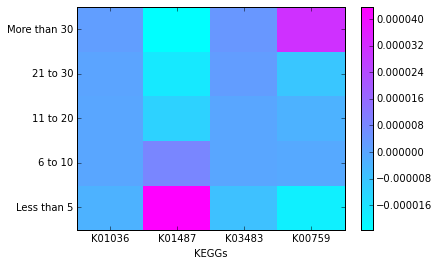

In [70]:
num_plant_types = ['Less than 5', '6 to 10', '11 to 20', '21 to 30', 'More than 30']
fig, ax = plt.subplots()

plant_tables = plant_df.groupby("TYPES_OF_PLANTS")
means = plant_tables.aggregate(np.mean)
plant_means = means.reindex(num_plant_types)
# Center each KEGG around its mean
M = plant_means.apply(lambda x: x - np.mean(x),axis=0).as_matrix()
im = ax.pcolor(M, cmap=matplotlib.cm.cool)
ax.set_xticks(np.arange(plant_means.shape[1])+0.5, minor=False)
ax.set_xticklabels(plant_keggs, minor=False)
ax.set_yticks(np.arange(plant_means.shape[0])+0.5, minor=False)
ax.set_yticklabels(num_plant_types, minor=False)

plt.xlabel('KEGGs')
plt.xlim([0,plant_means.shape[1]])

cbar_ax = fig.add_axes()
fig.colorbar(im, cax=cbar_ax)

We can notice a couple of interesting things here.

Note that K01036 and K03483 are mostly blue.  This indicates that the variance of these KEGGs pale in comparison to the K01487 and K00759.  We can double check this by calculating the variance of each of these KEGGs across all of the groups.

In [74]:
plant_df.var(axis=0)

K01036    8.919591e-11
K01487    9.388517e-09
K03483    8.929116e-10
K00759    1.700712e-08
dtype: float64

Another thing to notice is that K01487 and K00759 seem to be inversely correlated - when the proportion of K01487 is high, the proportion of K00759 is low.

Apparently, both of these KEGGs are involved in nucleotide metabolism.

[K01487](http://www.genome.jp/dbget-bin/www_bget?ko:K01487) encodes for [guanine deaminase](http://en.wikipedia.org/wiki/Guanine_deaminase), which converts guanine to xanthine.  Some bacterial species like Bacillus subtilis can use xanthine as a nitrogen source [3].  Bacillus subilis strains are very common in soil environments.  This would go against our intuition, since we would think that people who consume more types of plants should have higher abundances of soil bacteria.  But according to the heatmap, people who consume very few types of plants have higher proportions of enzymes that break down guanine.

[K00759](http://www.genome.jp/dbget-bin/www_bget?ko:K00759) encodes for [adenine phosphoribosyltransferase](http://en.wikipedia.org/wiki/Adenine_phosphoribosyltransferase).  This enzyme is critical for recycling free adenines, namely by converting free adenines to AMP [4].  Having a deficiency of this enzyme can cause kidney stones, since the free adenines won't be metabolized.  According to the heatmap, people who consume more types of plants have higher proportions of enzymes that break down adenine.

It is known that the ecosystem of the gut is a very dynamic system [5].  
To determine if there is a significant difference between months, we'll first bin all of the samples according to the collection time that was collected.  Then we will apply the same strategy that we used above.

In [41]:
# Sets up the category parameters
category = 'COLLECTION_MONTH'
base_cat = 'COLLECTION_DATE'

# Sets a function to convert the collection date, if necessary
def get_month(date_str):
    """converts a date to a month string"""
    if len(date_str) > 8:
        return strftime('%B', strptime(date_str, '%m/%d/%Y'))
    else:
        return strftime('%B', strptime(date_str, '%m/%d/%y'))
# Converts the collection date
if category not in metadata.columns:
    metadata[category]= metadata[base_cat].apply(get_month)

Since we anticipate the KEGG expression levels to wildly fluctuate over time, we are going to set a really small signficance value to single out KEGGs that are very likely to have different abundances over the months. 

In [75]:
accepted_month_keggs = kw_test(table, metadata, "COLLECTION_MONTH",alpha=10**-7)

Now, there are a TON of significant keggs associated with the collection month.  So we'll plot all of these signficiant KEGGs in a heatmap.

In [76]:
month_names = ['January', 'February', 'March', 'April', 'May', 'June', 
               'July', 'August', 'September', 'October', 'November', 
               'December']
month_keggs = [k[0] for k in accepted_month_keggs]
month_df = subset_dataframe(table=table, 
                            metadata=metadata, 
                            keggs=month_keggs, 
                            cat="COLLECTION_MONTH")

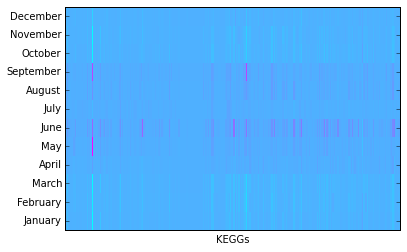

In [77]:
fig, ax = plt.subplots()

month_tables = month_df.groupby("COLLECTION_MONTH")
means = month_tables.aggregate(np.mean)
month_means = means.reindex(month_names)
# Center each KEGG around its mean
M = month_means.apply(lambda x: x - np.mean(x),axis=0).as_matrix()
ax.pcolor(M, cmap=matplotlib.cm.cool)
ax.set_yticks(np.arange(month_means.shape[0])+0.5, minor=False)
ax.set_yticklabels(month_names, minor=False)
#plt.colorbar()
plt.xlabel('KEGGs')
plt.xlim([0,month_means.shape[1]])
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off') # labels along the bottom edge are off

Let's repeat this analysis with the pathway information

In [78]:
biom_table = parse_biom_table(open(pathways_file))
df = pd.DataFrame()
for samp_v, samp_id, samp_md in biom_table.iterSamples():
    df[samp_id] = pd.Series(samp_v, index = biom_table.ObservationIds)
df = df.transpose()
# Filter out pathways with less than 1000 estimated genes
pwys = df.loc[:, df.sum(axis=0) > 1000]
# Trim out samples not in metadata
pwys = pwys.loc[metadata.index]
# Normalize all gene counts
pwys = pwys.div(table.sum(axis=1), axis=0)

In [79]:
accepted_month_pwys = kw_test(pwys, metadata, "COLLECTION_MONTH",alpha=10**-7)

In [80]:
month_names = ['January', 'February', 'March', 'April', 'May', 'June', 
               'July', 'August', 'September', 'October', 'November', 
               'December']
month_pwys = [k[0] for k in accepted_month_pwys]
month_df = subset_dataframe(table=pwys,
                            metadata=metadata, 
                            keggs=month_pwys, 
                            cat="COLLECTION_MONTH")

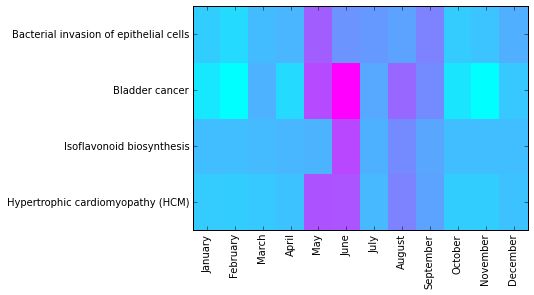

In [81]:
fig, ax = plt.subplots()

month_tables = month_df.groupby("COLLECTION_MONTH")
means = month_tables.aggregate(np.mean)
month_means = means.reindex(month_names)
# Center each pathway around its mean
M = month_means.apply(lambda x: x - np.mean(x),axis=0).as_matrix().T
ax.pcolor(M, cmap=matplotlib.cm.cool)
ax.set_yticks(np.arange(month_means.shape[1])+0.5, minor=False)
ax.set_yticklabels(month_pwys)
ax.set_xticks(np.arange(month_means.shape[0])+0.5, minor=False)
ax.set_xticklabels(month_names, minor=False, rotation=90)
plt.ylim([0,month_means.shape[1]])
fig.savefig('month_pathways.pdf', pad_inches=3)

# References

1. M. Langille, "Predictive functional profiling of microbial communities using 16S rRNA marker gene sequences", Nature Biotechnology, 2013
2. J. Leff, "Bacterial Communities Associated with the Surfaces of Fresh Fruits and Vegetables", PLOS ONE, 2013
3. P. Nygaardl, "Bacillus subtilis guanine deaminase is encoded by the yknA gene and is induced during growth with purines as the nitrogen source", Microbiology, 2000
4. J. Alfonzo, "APT1, but Not APT2, Codes for a Functional Adenine Phosphoribosyltransferase inSaccharomyces cerevisiae"
5. G. Caporaso, "Moving pictures of the human microbiome"